# De beaux graphiques avec python : mise en pratique

Lino Galiana  
2024-09-23

La pratique de la *data visualisation* se fera, dans ce cours, en répliquant des graphiques qu’on peut trouver sur
la page de l’*open data* de la ville de Paris
[ici](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/dataviz/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name) ou en proposant des alternatives à ceux-ci sur les mêmes données.

L’objectif de ce chapitre n’est pas de faire un inventaire complet des graphiques pouvant être fait avec `Python`, ce serait long, assez insipide et peu pertinent car des sites le font déjà très bien à partir d’une grande variété d’exemple, notamment le site [python-graph-gallery.com/](https://python-graph-gallery.com/). L’objectif est plutôt d’illustrer, par la pratique, quelques enjeux liés à l’utilisation des principales librairies graphiques de `Python`.

On peut distinguer quelques grandes familles de représentations graphiques: les représentations de distributions propres à une variable, les représentations de relations entre plusieurs variables, les cartes qui permettent de représenter dans l’espace une ou plusieurs variables…

Ces familles se ramifient elles-mêmes en de multiples types de figures. Par exemple, selon la nature du phénomène, les représentations de relations peuvent prendre la forme d’une série temporelle (évolution d’une variable dans le temps), d’un nuage de point (corrélation entre deux variables), d’un diagramme en barre (pour souligner le rapport relatif entre les valeurs d’une variable en fonction d’une autre), etc.

Plutôt qu’un inventaire à la Prévert des types de visualisations possibles, ce chapitre et le suivant vont plutôt proposer quelques visualisations qui pourraient donner envie d’aller plus loin dans l’analyse avant la mise en oeuvre d’une forme de modélisation. Ce chapitre est consacré aux visualisations traditionnelles, le [suivant](../../content/visualisation/maps.qmd) est dédié à la cartographie. Ces deux chapitres font partie d’un tout visant à offrir les premiers éléments pour synthétiser l’information présente dans un jeu de données.

Le pas suivant est d’approfondir le travail de communication et de synthèse par le biais de communications pouvant prendre des formes aussi diverses que des rapports, des publications scientifiques ou articles, des présentations, une application interactive, un site web ou des *notebooks* comme ceux proposés par ce cours. Le principe général est identique quelle que soit le *medium* utilisé et intéresse particulièrement les *data scientists* lorsqu’ils font appel à de l’exploitation intensive de données. Ce sera l’objet d’un chapitre futur de ce cours[1].

<div class="alert alert-danger" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-triangle-exclamation"></i> Important</h3>

Être capable de construire des visualisations de données
intéressantes est une compétence nécessaire à tout
*data scientist* ou chercheur. Pour améliorer
la qualité de ces visualisations, il est recommandé
de suivre certains conseils donnés par des spécialistes
de la *dataviz* sur la sémiologie graphique.

Les bonnes visualisations de données, comme celles du *New York Times*,
reposent certes sur des outils adaptés (des librairies `JavaScript`)
mais aussi sur certaines règles de représentation qui permettent
de comprendre en quelques secondes le message d’une visualisation.

Ce [post de blog](https://blog.datawrapper.de/text-in-data-visualizations/)
est une ressource qu’il est utile de consulter régulièrement.
Ce [post de blog d’Albert Rapp](https://albert-rapp.de/posts/ggplot2-tips/10_recreating_swd_look/10_recreating_swd_look) montre bien comment construire graduellement une bonne visualisation
de données.

</div>

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Compétences à l’issue de ce chapitre</h3>

-   Découvrir l’écosystème [`matplotlib`](https://matplotlib.org/) et
    [`seaborn`](https://seaborn.pydata.org/) pour la construction de graphiques par enrichissement successif de couches.
-   Découvrir le récent écosystème [`plotnine`](https://plotnine.readthedocs.io/en/stable/index.html).
    qui est une implémentation en `Python` du *package* `R` [`ggplot2`](https://ggplot2.tidyverse.org/)
    pour ce type de représentation et qui, grâce à sa grammaire des graphiques, offre une syntaxe puissante pour construire des visualisations de données.
-   Découvrir le principe des représentations interactives HTML (format *web*) grâce au package [`plotly`](https://plotly.com/python/).
-   Apprendre les enjeux de la représentation graphique, les compromis nécessaires pour construire un message clair et les limites de certaines représentations classiques.

</div>

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Note</h3>

Si vous êtes intéressés par `R` ,
une version très proche de ce TP est
disponible dans [ce cours d’introduction à `R` pour l’ENS Ulm](https://rgeo.linogaliana.fr/exercises/ggplot.html).

</div>

# 1. Données

Ce chapitre s’appuie sur les données de comptage des passages de vélo dans les points de mesure parisiens diffusés sur le site de l’*open data* de la ville de Paris.

L’exploitation de l’historique récent a été grandement facilité par la diffusion des données au format `Parquet`, un format moderne plus pratique que le CSV. Pour en savoir plus sur ce format, vous pouvez consulter les ressources évoquées dans le paragraphe consacré à ce format dans le [chapitre d’approfondissement](../../content/manipulation/02_pandas_suite.qmd).

[1] Ce chapitre sera construit autour de l’écosystème [`Quarto`](https://quarto.org/). En attendant ce chapitre, vous pouvez consulter la documentation exemplaire de cet écosystème et pratiquer, ce sera le meilleur moyen de découvrir.

In [1]:
import os
import requests
from tqdm import tqdm
import pandas as pd
import duckdb

url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/comptage-velo-donnees-compteurs/exports/parquet?lang=fr&timezone=Europe%2FParis"
filename = "comptage_velo_donnees_compteurs.parquet"


# DOWNLOAD FILE --------------------------------

# Perform the HTTP request and stream the download
response = requests.get(url, stream=True)

if not os.path.exists(filename):
    # Perform the HTTP request and stream the download
    response = requests.get(url, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Get the total size of the file from the headers
        total_size = int(response.headers.get("content-length", 0))

        # Open the file in write-binary mode and use tqdm to show progress
        with open(filename, "wb") as file, tqdm(
            desc=filename,
            total=total_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            # Write the file in chunks
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:  # filter out keep-alive chunks
                    file.write(chunk)
                    bar.update(len(chunk))
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
else:
    print(f"The file '{filename}' already exists.")

# READ FILE AND CONVERT TO PANDAS --------------------------

query = """
SELECT id_compteur, nom_compteur, id, sum_counts, date 
FROM read_parquet('comptage_velo_donnees_compteurs.parquet')
"""

# READ WITH DUCKDB AND CONVERT TO PANDAS
df = duckdb.sql(query).df()

df.head(3)


comptage_velo_donnees_compteurs.parquet: 0.00B [00:00, ?B/s]comptage_velo_donnees_compteurs.parquet: 79.0kB [00:00, 599kB/s]comptage_velo_donnees_compteurs.parquet: 399kB [00:00, 1.62MB/s]comptage_velo_donnees_compteurs.parquet: 1.64MB [00:00, 5.13MB/s]comptage_velo_donnees_compteurs.parquet: 6.62MB [00:00, 17.7MB/s]comptage_velo_donnees_compteurs.parquet: 11.2MB [00:00, 18.3MB/s]

# 2. Premières productions graphiques avec l’API `Matplotlib` de `Pandas`

Chercher à produire une visualisation parfaite du premier coup est
illusoire. Il est beaucoup plus réaliste d’améliorer graduellement
une représentation graphique afin, petit à petit, de mettre en
avant les effets de structure dans un jeu de données.

Nous allons donc commencer par nous représenter la distribution
des passages aux principales stations de mesure.
Pour cela nous allons produire
rapidement un *barplot* puis l’améliorer graduellement.

Dans cette partie, nous allons ainsi
reproduire les deux premiers graphiques de la
[page d’analyse des données](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/dataviz/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name) :
*Les 10 compteurs avec la moyenne horaire la plus élevée* et *Les 10 compteurs ayant comptabilisé le plus de vélos*. Les valeurs chiffrées des graphiques peuvent être différentes de celles de la page en ligne, c’est normal, car nous ne travaillons pas systématiquement sur les données ayant la même fraicheur que celles en ligne.

Pour importer les librairies graphiques que nous utiliserons dans ce chapitre, il faut faire

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

## 2.1 Comprendre, en quelques mots, le principe de `matplotlib`

`matplotlib` date du début des années 2000 et a émergé pour proposer une alternative en `Python` à la création de graphiques sous `Matlab`, un logiciel propriétaire de calcul numérique. `matplotlib` est donc une librairie assez ancienne, antérieure à l’émergence de `Python` dans l’écosystème du traitement de données. Cela s’en ressent sur la logique de construction de `matplotlib` qui n’est pas toujours intuitive lorsqu’on est familier de l’écosystème moderne de la *data science*. Heureusement, il existe de nombreuses librairies qui s’appuient sur `matplotlib` mais qui visent à founir une syntaxe plus familière aux *data scientists*.

`matplotlib` propose principalement deux niveaux d’abstraction: la figure et les axes. La figure est, en quelques sortes, la “toile” globale qui contient un ou plusieurs axes dans lesquels s’inséreront des graphiques. Selon les cas, il faudra jouer avec les paramètres de figure ou d’axe, ce qui rend très flexible la construction d’un graphique mais peut également être déroutant car on ne sait jamais trop quel niveau d’abstraction il faut modifier pour mettre à jour sa figure[1]. Comme le montre la <a href="#fig-matplotlib" class="quarto-xref">Figure 2.1</a>, tout les éléments d’une figure sont paramétrables.

<figure id="fig-matplotlib">
<img src="https://matplotlib.org/stable/_images/anatomy.png" />
<figcaption>Figure 2.1: Comprendre l’architecture d’une figure <code>matplotlib</code> (Source: <a href="https://matplotlib.org/stable/users/explain/quick_start.html">documentation officielle</a>)</figcaption>
</figure>

En pratique, il existe deux manières de créer et mettre à jour sa figure selon qu’on préfère passer par:

-   l’approche explicite, héritière d’une logique de programmation orientée objet, où on crée des objets `Figure` et `Axes` et met à jour ceux-ci.
-   l’approche implicite, basée sur l’interface `pyplot` qui utilise une succession de fonctions pour mettre à jour les objets créés implicitement.

## Approche explicite (approche orientée POO)

``` python
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2, 100)  # Sample data.

# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(5, 2.7), layout="constrained")
ax.plot(x, x, label="linear")  # Plot some data on the Axes.
ax.plot(x, x**2, label="quadratic")  # Plot more data on the Axes...
ax.plot(x, x**3, label="cubic")  # ... and some more.
ax.set_xlabel("x label")  # Add an x-label to the Axes.
ax.set_ylabel("y label")  # Add a y-label to the Axes.
ax.set_title("Simple Plot")  # Add a title to the Axes.
ax.legend()  # Add a legend.
```

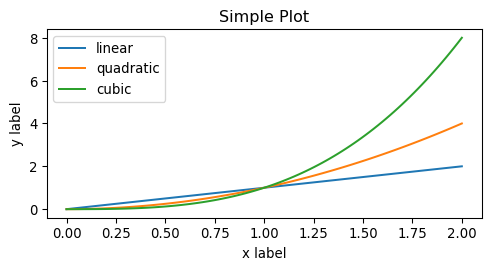

Source: [Documentation officielle de `matplotlib`](https://matplotlib.org/stable/users/explain/quick_start.html)

## Approche implicite

``` python
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2, 100)  # Sample data.

plt.figure(figsize=(5, 2.7), layout="constrained")
plt.plot(x, x, label="linear")  # Plot some data on the (implicit) Axes.
plt.plot(x, x**2, label="quadratic")  # etc.
plt.plot(x, x**3, label="cubic")
plt.xlabel("x label")
plt.ylabel("y label")
plt.title("Simple Plot")
plt.legend()
```

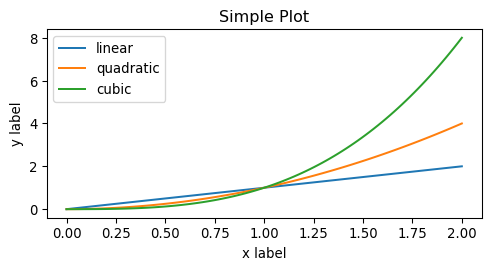

Source: [Documentation officielle de `matplotlib`](https://matplotlib.org/stable/users/explain/quick_start.html)

Ces éléments constituent le minimum pour comprendre la logique de `matplotlib`. Pour être plus à l’aise avec ces concepts, la pratique répétée est indispensable.

## 2.2 Découvrir `matplotlib` par l’intermédiaire de `Pandas`

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1 : Produire un premier graphique</h3>

Les données comportent plusieurs dimensions pouvant faire l’objet d’une analyse statistique. Nous allons commencer par nous focaliser sur le volume de passage à tel ou tel compteur.

Puisque nous avons comme objectif de synthétiser l’information présente dans notre jeu de données, nous devons d’abord mettre en oeuvre quelques agrégations *ad hoc* pour produire un
graphique lisible.

1.  Garder les dix bornes à la moyenne la plus élevée. Comme pour obtenir un graphique ordonné du plus grand au plus petit avec les méthodes `plot` de `Pandas`, il faut avoir les données ordonnées du plus petit au plus grand (oui c’est bizarre mais c’est comme ça…), réordonner les données.

2.  En premier lieu, sans se préoccuper des éléments de style ni de la beauté
    du graphique, créer la structure du *barplot* (diagramme en batons) de la
    [page d’analyse des données](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/dataviz/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name).

3.  Pour préparer le travail sur la deuxième figure, ne conserver
    que les 10 compteurs ayant comptabilisés le plus de vélos.

4.  Comme pour la question 2, créer un *barplot*
    pour reproduire la figure 2 de l’*open data* parisien

</div>

Les 10 principales stations à l’issue de la question 1

[1] Heureusement, comme il existe un énorme corpus de code en ligne utilisant `matplotlib`, les assistants de code comme `ChatGPT` ou `Github Copilot` sont précieux pour construire un graphique à partir d’instructions.

Figure 1 sans travail sur le style:

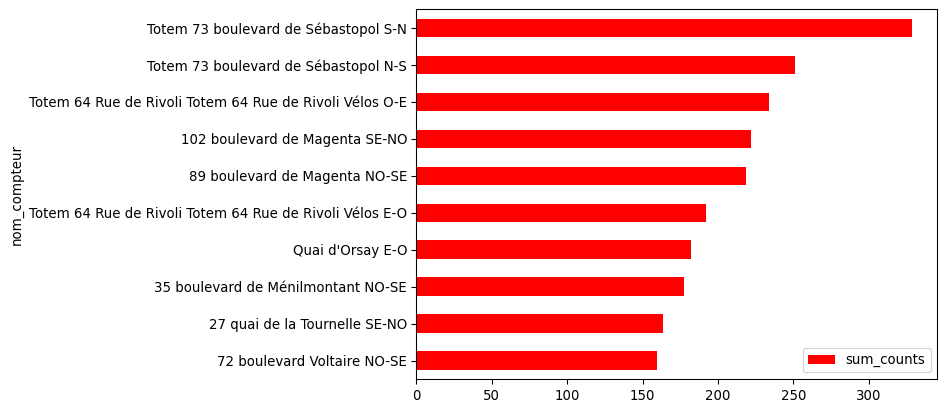

<details>
<summary>
Figure 2 sans travail sur le style:
</summary>

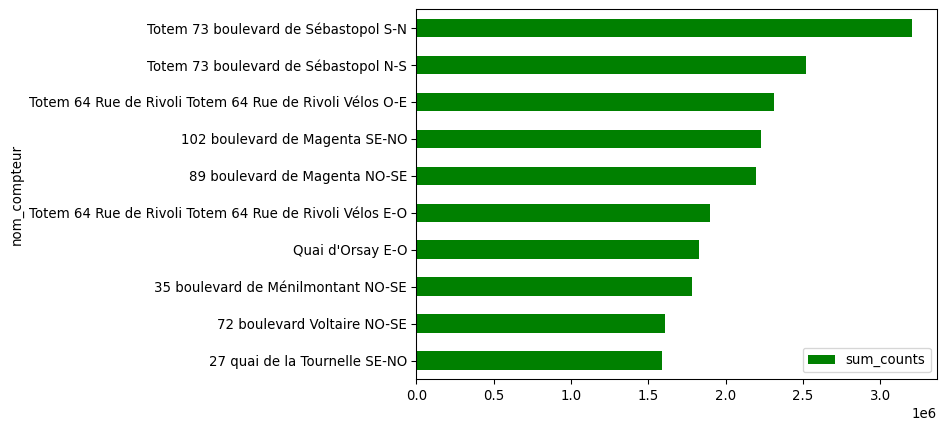

</details>

On commence à avoir quelque chose qui commence à transmettre
un message synthétique sur la nature des données.
On peut néanmoins remarquer plusieurs éléments problématiques
(par exemple les labels) mais
aussi des éléments ne correspondant pas (les titres des axes, etc.) ou
manquants (le nom du graphique…).

Comme les graphiques produits par `Pandas` suivent la logique très flexible de `matplotlib`, il est possible de les customiser. Cependant, cela demande généralement beaucoup de travail et la grammaire `matplotlib` n’est pas aussi normalisée que celle de `ggplot` en `R`.
Si on désire rester dans l’écosystème `matplotlib`, il est préférable de directement utiliser `seaborn`, qui offre quelques arguments prêts à l’emploi. Sinon on peut basculer sur l’écosystème `plotnine` qui offrira une syntaxe normalisée pour modifier les différents

# 3. Utiliser directement `seaborn`

## 3.1 Comprendre `seaborn` en quelques lignes

`seaborn` est une interface haut niveau au dessus de `matplotlib`. Ce package offre un ensemble de fonctionnalités pour créer des figures ou des axes `matplotlib` directement depuis une fonction admettant de nombreux arguments et, si besoin d’aller plus loin dans la customisation, d’utiliser les fonctionnalités de `matplotlib` pour mettre à jour la figure, que ce soit par le biais de l’approche implicite ou explicite décrites précédemment.

Comme pour `matplotlib`, `seaborn` permet de faire la même figure de multiples manières. `seaborn` hérite de la dualité axes-figures de `matplotlib` et il faudra souvent jouer avec un niveau ou l’autre. La principale caractéristique de `seaborn` est d’offrir quelques points d’entrées standardisés, par exemple `seaborn.relplot` ou `seaborn.catplot`, et une logique d’*inputs* basée sur le `DataFrame` là où `matplotlib` est structurée autour du *array* `Numpy`.

La figure comporte maintenant un message mais il est encore peu
lisible. Il y a plusieurs manières de faire un *barplot* en `seaborn`. Les deux principales
sont :

-   `sns.catplot` ;
-   `sns.barplot`.

On propose d’utiliser `sns.catplot` pour cet exercice. Il s’agit d’un point d’entrée assez fréquent pour faire des graphiques d’une variable discrétisée.

## 3.2 Le diagramme en barre (*barplot*)

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 2: reproduire la première figure avec seaborn</h3>

1.  Réinitialiser l’index des *dataframes* `df1` et `df2`
    pour avoir une colonne *‘Nom du compteur’*. Réordonner les données
    de manière décroissante pour obtenir un graphique ordonné dans
    le bon sens avec `seaborn`.

2.  Refaire le graphique précédent avec la fonction `catplot` de `seaborn`. Pour
    contrôler la taille du graphique vous pouvez utiliser les arguments `height` et
    `aspect`.

3.  Ajouter les titres des axes et le titre du graphique pour le premier graphique

4.  Essayez de colorer en rouge l’axe des `x`. Vous pouvez pré-définir un
    style avec `sns.set_style("ticks", {"xtick.color": "red"})`

</div>

A l’issue de la question 2, c’est-à-dire en utilisant
`seaborn` pour reproduire de manière minimale
un *barplot*, on obtient :

Après quelques réglages esthétiques, à l’issue des questions 3 et 4,
on obtient une figure proche de celle du portail *open data* parisien.

Les paramètres supplémentaires proposés à la question 4 permettent finalement d’obtenir la figure

On comprend ainsi que le boulevard de Sébastopol est le plus emprunté,
ce qui ne vous suprendra pas si vous faites du vélo à Paris.
Néanmoins, si vous n’êtes pas familiers avec la géographie parisienne,
cela sera peu informatif pour vous, vous allez avoir besoin d’une
représentation graphique supplémentaire: une carte ! Nous verrons
ceci lors d’un prochain chapitre.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 2bis : reproduire la figure “Les 10 compteurs ayant comptabilisé le plus de vélos”</h3>

En suivant l’approche graduelle de l’exercice 2,
refaire le graphique *Les 10 compteurs ayant comptabilisé le plus de vélos*
avec `seaborn`

</div>

## 3.3 Un exemple d’alternative au *barplot*, le *lollipop chart*

Les diagrammes en batons (*barplot*) sont extrêmement communs, sans doute à cause de l’héritage d’Excel où ces graphiques sont faisables en deux clics. Néanmoins, en ce qui concerne le message à transmettre, ils sont loin d’être parfaits. Par exemple, les barres prennent beaucoup d’espace visuel
ce qui peut brouiller le message à transmettre sur le rapport entre les observations.

Sur le plan sémiologique, c’est à dire sur le plan de l’efficacité du message à transmettre,
les *lollipop charts* sont préférables : ils
transmettent la même information mais avec moins de signes visuels pouvant brouiller sa compréhension.

Les *lollipop chart* ne sont pas parfaits non plus mais sont un peu plus efficaces pour transmettre le message. Pour en savoir plus sur les alternatives au *barplot*, la conférence d’Eric Mauvière pour le réseau des *data scientists* de la statistique publique, dont le message principal est *“Désempilez vos figures”* mérite le détour ([disponible sur le site ssphub.netlify.app/](https://ssphub.netlify.app/talk/2024-02-29-mauviere/))

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 3 (optionnel) : reproduire la figure 2 avec un lollipop chart</h3>

En suivant l’approche graduelle de l’exercice 2,
refaire le graphique *Les 10 compteurs ayant comptabilisé le plus de vélos*.

💡 Ne pas hésiter à consulter [python-graph-gallery.com/](https://python-graph-gallery.com/) ou à demander de l’aide à `ChatGPT`

</div>

Text(0, 0.5, 'La somme des vélos comptabilisés sur la période sélectionnée')

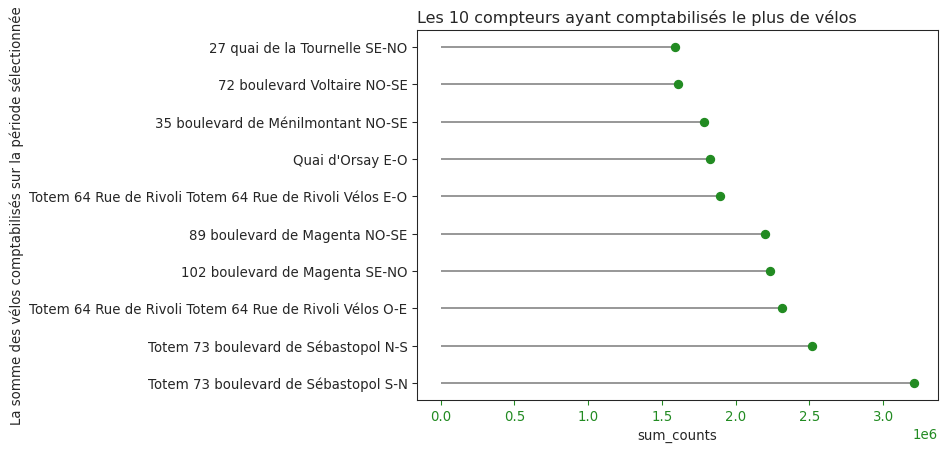

# 4. La même figure avec `plotnine`

`plotnine` est le nouveau venu dans l’écosystème de la visualisation en `Python`. Cette librairie est développée par `Posit`, l’entreprise à l’origine de l’éditeur `RStudio` et de l’écosystème du *tidyverse* si central dans le langage `R`. Cette librairie vise à importer la logique de `ggplot` en `Python` c’est à dire une grammaire des graphiques normalisée, lisible et flexible héritère de Wilkinson (2012).

<figure>
<img src="https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/elmo.jpg" alt="L’état d’esprit des habitués de ggplot2 quand ils découvrent plotnine" />
<figcaption aria-hidden="true">L’état d’esprit des habitués de <code>ggplot2</code>
quand ils découvrent <code>plotnine</code></figcaption>
</figure>

Dans cette approche, un graphique est vu comme une succession de couches qui, une fois superposées, donneront la figure suivante. En soi, ce principe n’est pas différent de celui de `matplotlib`. Néanmoins, la grammaire utilisée par `plotnine` est beaucoup plus intuitive et normalisée ce qui offrira beaucoup plus d’autonomie pour modifier sa figure.

<figure>
<img src="https://psyteachr.github.io/data-skills-v2/images/corsi/layers.png" alt="La logique de ggplot (et plotnine) par Lisa (2021), image elle-même empruntée à Field (2012)" />
<figcaption aria-hidden="true">La logique de <code>ggplot</code> (et <code>plotnine</code>) par <span class="citation" data-cites="Lisa_psyTeachR_Book_Template_2021">Lisa (2021)</span>, image elle-même empruntée à <span class="citation" data-cites="field2012discovering">Field (2012)</span></figcaption>
</figure>

Avec `plotnine`, il n’y a plus de point d’entrée dual figure-axe. Comme l’illustrent les slides ci-dessous, :

1.  On initialise une figure
2.  On met à jour les couches (*layers*), un niveau d’abstraction très général concernant aussi bien les données représentées que les échelles des axes ou la couleur
3.  A la fin, on peut jouer sur l’esthétique en modifiant les labels des axes, de la légende, les titres, etc.

<div class="sourceCode" id="cb1"><pre class="sourceCode yaml code-with-copy"><code class="sourceCode yaml"></code><button title="Copy to Clipboard" class="code-copy-button"><i class="bi"></i></button></pre><iframe class="sourceCode yaml code-with-copy" src="https://rgeo.linogaliana.fr/slides/ggplot.html#/ggplot2"></iframe></div>

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 4: reproduire la première figure avec plotnine</h3>

Ceci est le même exercice que l’exercice 2. L’objectif est de faire cette figure avec `plotnine`

</div>

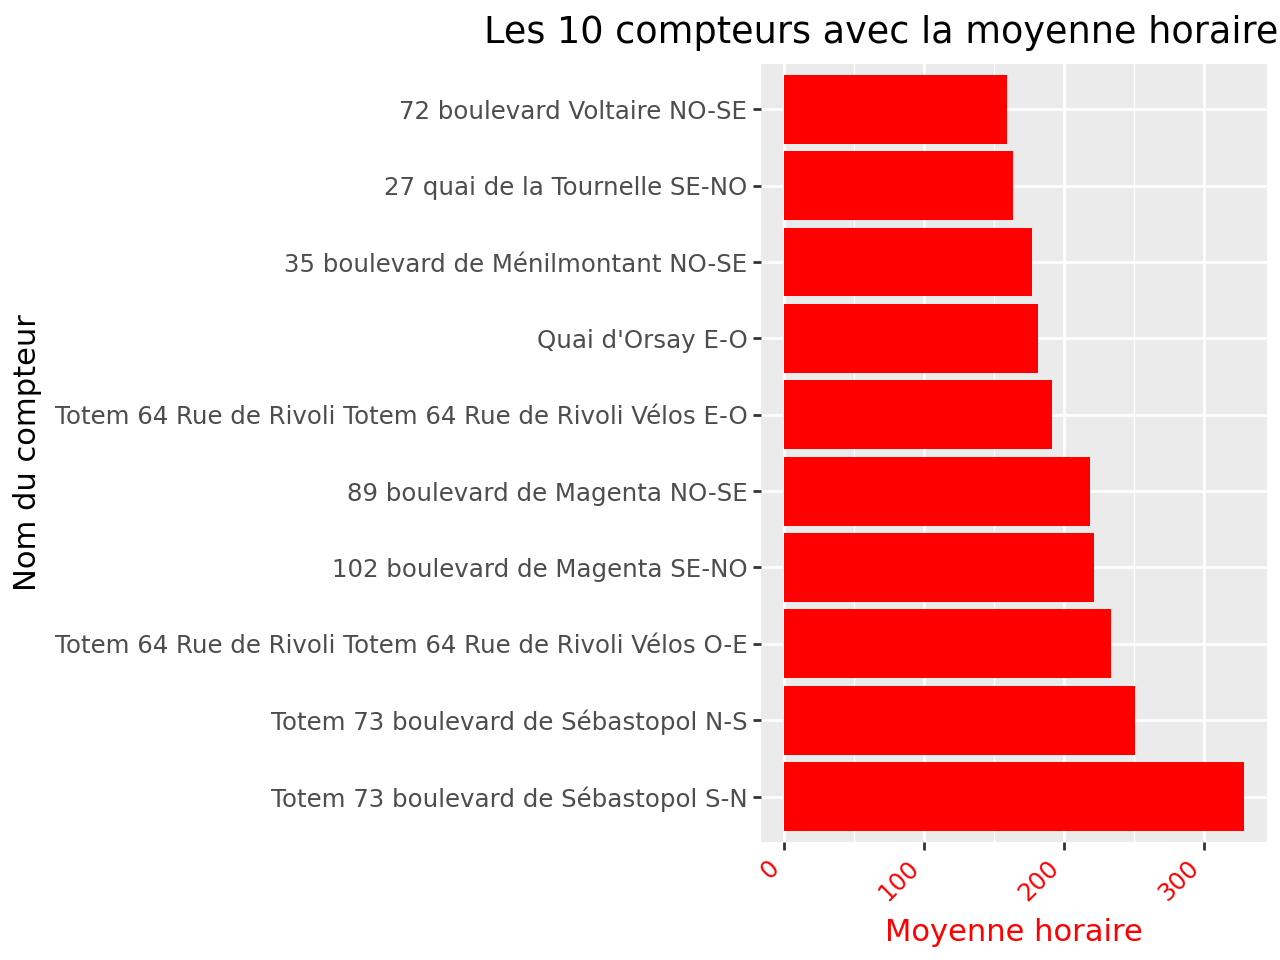

# 5. Premières agrégations temporelles

On va maintenant se concentrer sur la dimension temporelle de notre
jeu de données à travers deux approches :

-   Un diagramme en barre synthétisant l’information de notre jeu de données
    de manière mensuelle ;
-   Des séries instructives sur la dynamique temporelle. Cela sera l’objet de la prochaine partie.

Avant cela, nous allons enrichir ces données pour bénéficier d’un historique plus long, permettant notamment d’avoir la période Covid dans nos données, ce qui présente un intérêt du fait de la dynamique particulière du trafic dans cette période (arrêt brutal, reprise très forte…).

In [20]:
import requests
import zipfile
import io
import os
import pandas as pd
import geopandas as gpd

list_useful_columns = [
    "Identifiant du compteur",
    "Nom du compteur",
    "Identifiant du site de comptage",
    "Nom du site de comptage",
    "Comptage horaire",
    "Date et heure de comptage",
]


# GENERIC FUNCTION TO RETRIEVE DATA -------------------------


def download_unzip_and_read(url, extract_to="."):
    """
    Downloads a zip file from the specified URL, extracts its contents, and reads the CSV file based on the filename pattern in the URL.

    Parameters:
    - url (str): The URL of the zip file to download.
    - extract_to (str): The directory where the contents of the zip file should be extracted.

    Returns:
    - df (DataFrame): The loaded pandas DataFrame from the extracted CSV file.
    """
    try:
        # Extract the file pattern from the URL (filename without the extension)
        file_pattern = url.split("/")[-1].replace("_zip/", "")

        # Send a GET request to the specified URL to download the file
        response = requests.get(url)
        response.raise_for_status()  # Ensure we get a successful response

        # Create a ZipFile object from the downloaded bytes
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Extract all the contents to the specified directory
            z.extractall(path=extract_to)
            print(f"Extracted all files to {os.path.abspath(extract_to)}")

            # Look for the file matching the pattern
            extracted_files = os.listdir(extract_to)
            csv_filename = [
                f for f in extracted_files if file_pattern in f and f.endswith(".csv")
            ]

            if not csv_filename:
                print(f"No file matching pattern '{file_pattern}' found.")
                return None

            # Read the first matching CSV file into a pandas DataFrame
            csv_path = os.path.join(extract_to, csv_filename[0])
            print(f"Reading file: {csv_path}")
            df = pd.read_csv(csv_path, sep=";")

            # CONVERT TO GEOPANDAS
            df[["latitude", "longitude"]] = df["Coordonnées géographiques"].str.split(
                ",", expand=True
            )
            df["latitude"] = pd.to_numeric(df["latitude"])
            df["longitude"] = pd.to_numeric(df["longitude"])
            gdf = gpd.GeoDataFrame(
                df, geometry=gpd.points_from_xy(df.longitude, df.latitude)
            )
            # CONVERT TO TIMESTAMP
            df["Date et heure de comptage"] = pd.to_datetime(
                df["Date et heure de comptage"],
                format="%Y-%m-%dT%H:%M:%S",
                errors="coerce",
            )
            gdf = df.loc[:, list_useful_columns]
            return gdf

    except requests.exceptions.RequestException as e:
        print(f"Error: The downloaded file has not been found: {e}")
        return None
    except zipfile.BadZipFile as e:
        print(f"Error: The downloaded file is not a valid zip file: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def read_historical_bike_data(year):
    dataset = "comptage_velo_donnees_compteurs"
    url_comptage = f"https://opendata.paris.fr/api/datasets/1.0/comptage-velo-historique-donnees-compteurs/attachments/{year}_{dataset}_csv_zip/"
    df_comptage = download_unzip_and_read(
        url_comptage, extract_to=f"./extracted_files_{year}"
    )
    if df_comptage is None:
        url_comptage_alternative = url_comptage.replace("_csv_zip", "_zip")
        df_comptage = download_unzip_and_read(
            url_comptage_alternative, extract_to=f"./extracted_files_{year}"
        )
    return df_comptage


# IMPORT HISTORICAL DATA -----------------------------

historical_bike_data = pd.concat(
    [read_historical_bike_data(year) for year in range(2018, 2024)]
)

rename_columns_dict = {
    "Identifiant du compteur": "id_compteur",
    "Nom du compteur": "nom_compteur",
    "Identifiant du site de comptage": "id",
    "Nom du site de comptage": "nom_site",
    "Comptage horaire": "sum_counts",
    "Date et heure de comptage": "date",
}


historical_bike_data = historical_bike_data.rename(columns=rename_columns_dict)


# IMPORT LATEST MONTHS ----------------

import os
import requests
from tqdm import tqdm
import pandas as pd
import duckdb

url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/comptage-velo-donnees-compteurs/exports/parquet?lang=fr&timezone=Europe%2FParis"
filename = "comptage_velo_donnees_compteurs.parquet"


# DOWNLOAD FILE --------------------------------

# Perform the HTTP request and stream the download
response = requests.get(url, stream=True)

if not os.path.exists(filename):
    # Perform the HTTP request and stream the download
    response = requests.get(url, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Get the total size of the file from the headers
        total_size = int(response.headers.get("content-length", 0))

        # Open the file in write-binary mode and use tqdm to show progress
        with open(filename, "wb") as file, tqdm(
            desc=filename,
            total=total_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            # Write the file in chunks
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:  # filter out keep-alive chunks
                    file.write(chunk)
                    bar.update(len(chunk))
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
else:
    print(f"The file '{filename}' already exists.")


# READ FILE AND CONVERT TO PANDAS
query = """
SELECT id_compteur, nom_compteur, id, sum_counts, date 
FROM read_parquet('comptage_velo_donnees_compteurs.parquet')
"""

# READ WITH DUCKDB AND CONVERT TO PANDAS
df = duckdb.sql(query).df()

df.head(3)


# PUT THEM TOGETHER ----------------------------

historical_bike_data = historical_bike_data.loc[
    historical_bike_data["date"] < df["date"].min()
]

df = pd.concat([historical_bike_data, df])


Pour commencer, reproduisons la troisième figure qui est, encore une fois,
un *barplot*. Ici, sur le plan sémiologique, ce n’est pas justifier d’utiliser un *barplot*, une simple série suffirait à fournir une information similaire.

La première question du prochain exerice implique une première rencontre avec
une donnée temporelle à travers une opération assez classique en séries
temporelles : changer le format d’une date pour pouvoir faire une agrégation
à un pas de temps plus large.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 5: barplot des comptages mensuels</h3>

1.  Créer une variable `month`
    dont le format respecte, par exemple, le schéma `2019-08` grâce à la bonne option de la méthode `dt.to_period`
2.  Appliquer les conseils précédents pour construire et améliorer
    graduellement un graphique afin d’obtenir une figure similaire
    à la 3e production sur la page de l’*open data* parisien. Faire cette figure d’abord depuis début 2022 puis sur toute la période de notre historique
3.  Question optionnelle: représenter la même information sous forme de *lollipop*

</div>

La figure avec les données depuis début 2022 aura cet aspect si elle a été construite avec `plotnine`:

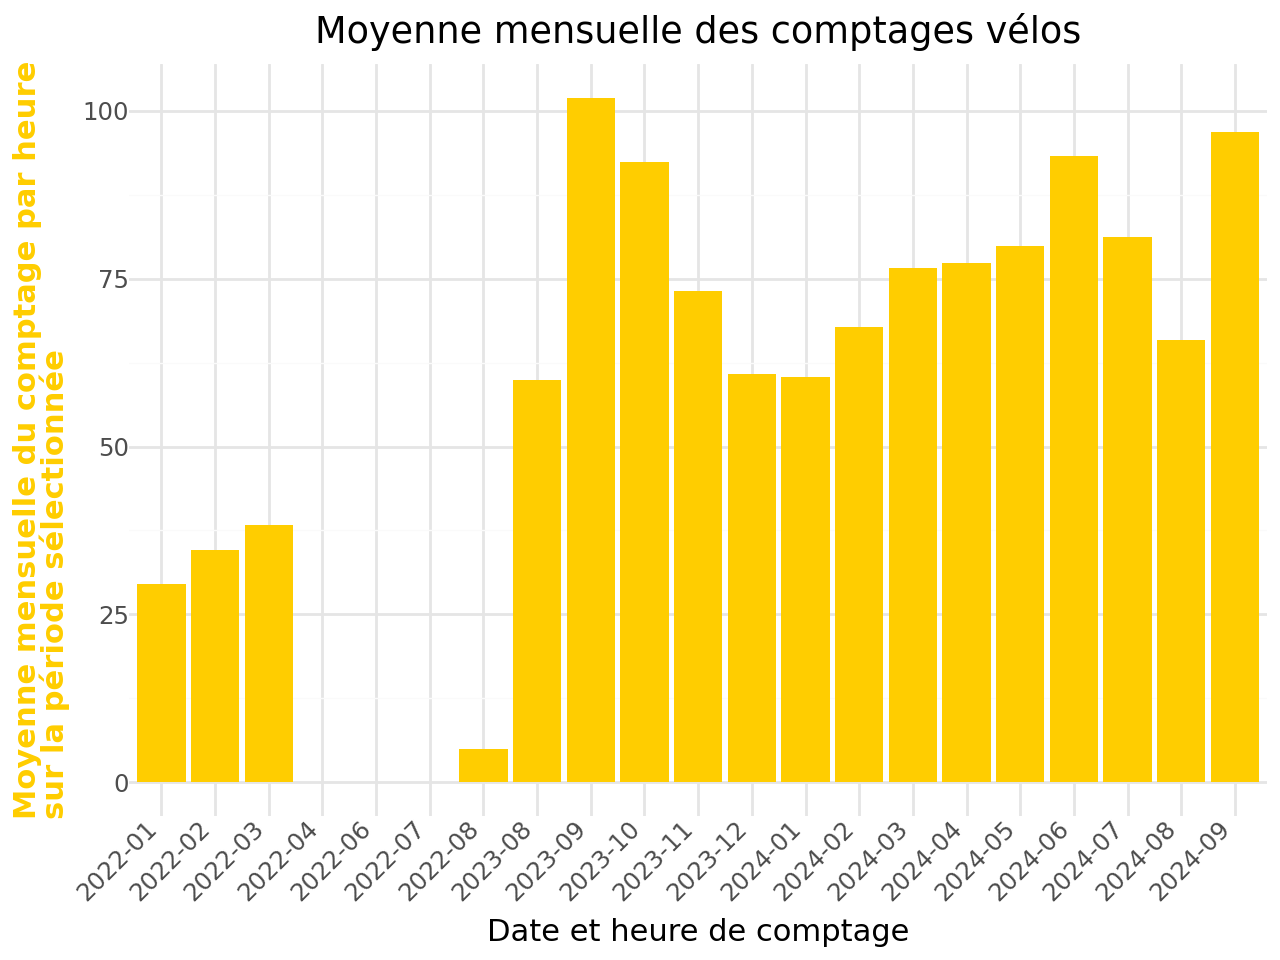

Avec `seaborn`, elle ressemblera plutôt à ceci:

Text(0.5, 1.0, 'Moyenne mensuelle des comptages vélos')

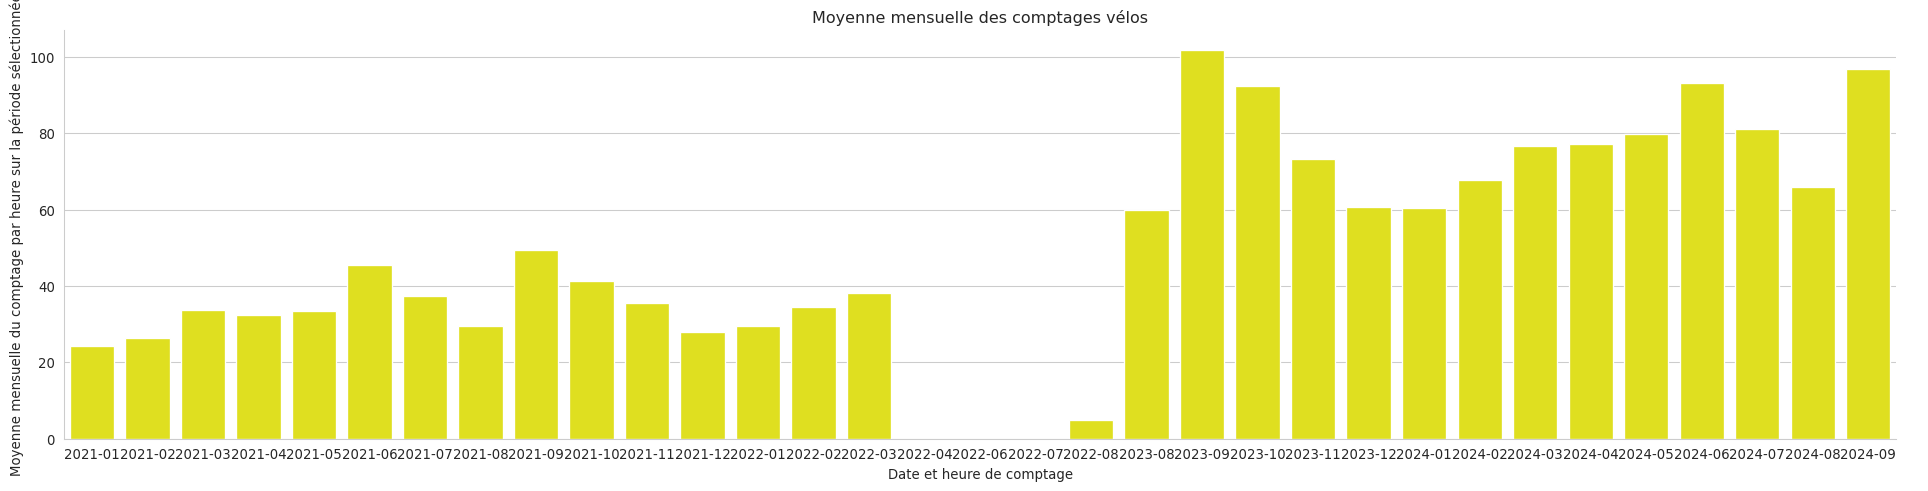

Si vous préférez représenter cela sous forme de *lollipop*[1]:

[1] J’ai retiré la couleur sur l’axe des ordonnées qui, je trouve,
apporte peu à la figure voire dégrade la compréhension du message.

/opt/mamba/lib/python3.11/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().

Enfin, sur l’ensemble de la période, la série prendra plutôt cette forme:

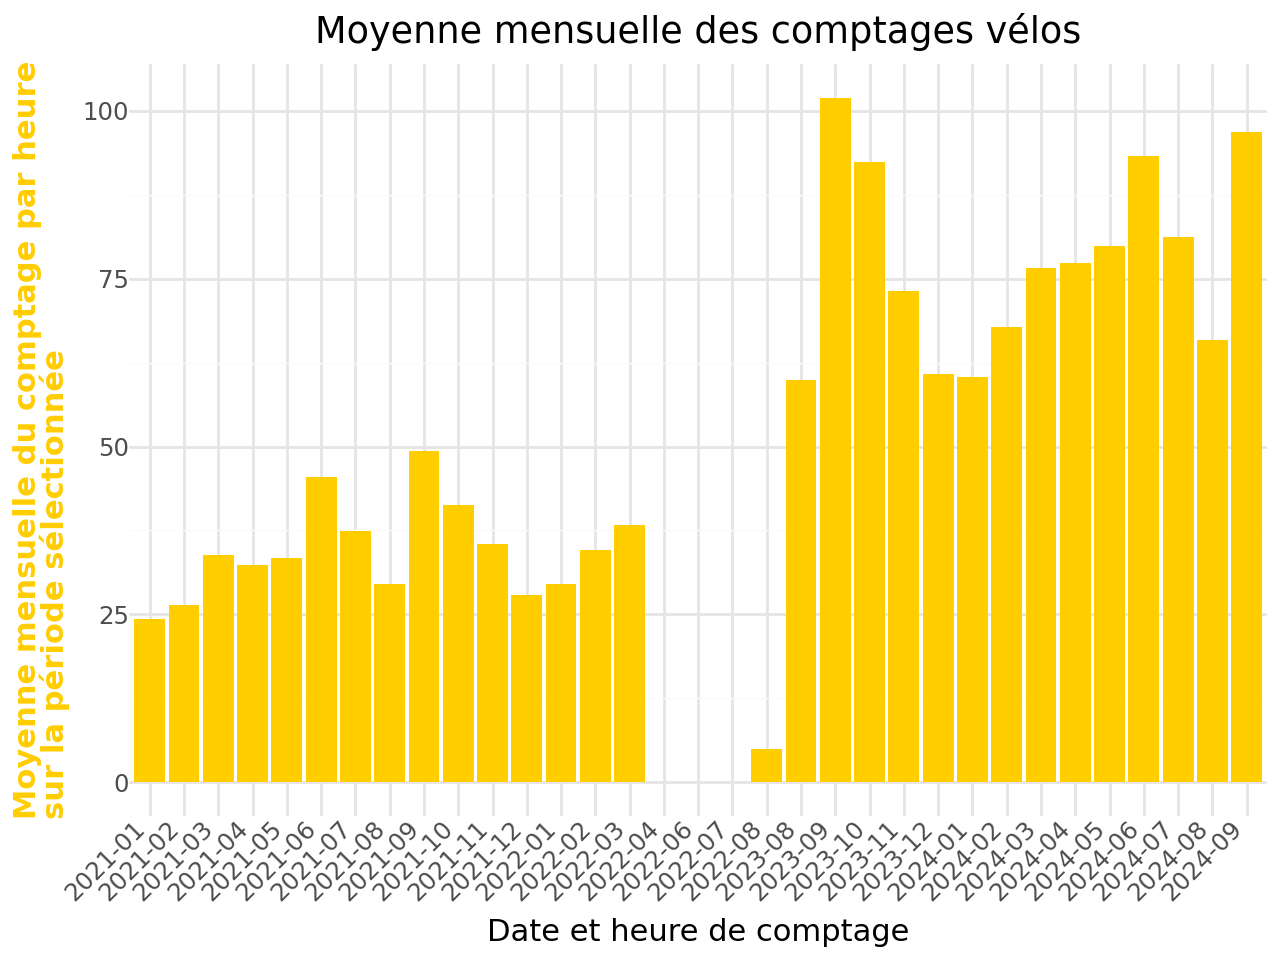

# 6. Première série temporelle

Il est plus commun de représenter sous forme de série
les données ayant une dimension temporelle.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 5: barplot des comptages mensuels</h3>

1.  Créer une variable `day` qui transforme l’horodatage en format journalier
    du type `2021-05-01` avec `dt.day`.
2.  Reproduire la figure de la page d’*open data*

</div>

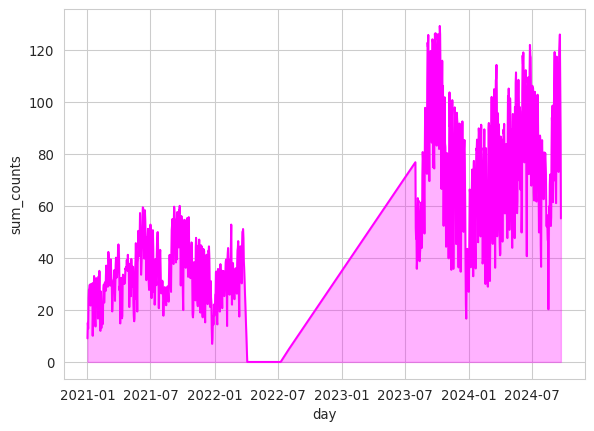

# 7. Des graphiques dynamiques avec `Plotly`

## 7.1 Contexte

L’inconvénient des figures avec `ggplot` est que celles-ci ne permettent
pas d’interaction avec le lecteur. Toute l’information doit donc être
contenue dans la figure ce qui peut la rendre difficile à lire.
Si la figure est bien faite, avec différents niveaux d’information, cela
peut bien fonctionner.

Il est néanmoins plus simple, grâce aux technologies *web*, de proposer des
visualisations à plusieurs niveaux. Un premier niveau d’information, celui du
coup d’oeil, peut suffire à assimiler les principaux messages de la
visualisation. Ensuite, un comportement plus volontaire de recherche
d’information secondaire peut permettre d’en savoir plus. Les visualisations
réactives, qui sont maintenant la norme dans le monde de la *dataviz*,
permettent ce type d’approche : le lecteur d’une visualisation peut passer
sa souris à la recherche d’information complémentaire (par exemple les
valeurs exactes) ou cliquer pour faire apparaître des informations complémentaires
sur la visualisation ou autour.

Ces visualisations reposent sur le même triptyque que l’ensemble de l’écosystème
*web* : `HTML`, `CSS` et `JavaScript`. Les utilisateurs de `Python`
ne vont jamais manipuler directement ces langages, qui demandent une
certaine expertise, mais vont utiliser des librairies au niveau de `R` qui génèreront automatiquement tout le code `HTML`, `CSS` et `JavaScript`
permettant de créer la figure.

## 7.2 La librairie `Plotly`

Le package `Plotly` est une surcouche à la librairie `Javascript`
`Plotly.js` qui permet de créer et manipuler des objets graphiques de manière
très flexible afin de produire des objets réactifs sans avoir à recourir
à Javascript.

Le point d’entrée recommandé est le module `plotly.express`
([documentation ici](https://plotly.com/python/plotly-express/)) qui offre une arborescence
riche mais néanmoins intuitive pour construire des graphiques
(objets `plotly.graph_objects.Figure`) pouvant être modifiés *a posteriori*
si besoin (par exemple pour *customiser* les axes).

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Visualiser les figures produites par <code>Plotly</code></h3>

Dans un notebook Jupyter classique, les lignes suivantes de code permettent
d’afficher le résultat d’une commande `Plotly` sous un bloc de code :

``` python
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
```

Pour `JupyterLab`, l’extension `jupyterlab-plotly` s’avère nécessaire:

``` python
!jupyter labextension install jupyterlab-plotly
```

</div>

## 7.3 Réplication de l’exemple précédent avec `Plotly`

Les représentations figées comme celles ci-dessus
sont approriées pour des rapports ou articles.
Néanmoins

Les modules suivants seront nécessaires pour construire des graphiques
avec `plotly`:

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 7: un barplot avec <code>Plotly</code></h3>

L’objectif est de reconstuire le premier diagramme en barre rouge avec `Plotly`.

1.  Réalisez le graphique en utilisant la fonction adéquate avec `plotly.express` et…
    -   Ne pas prendre le
        thème par défaut mais un à fond blanc, pour avoir un résultat ressemblant
        à celui proposé sur le site de l’*open-data*.
    -   Pour la couleur rouge,
        vous pouvez utiliser l’argument `color_discrete_sequence`.
    -   Ne pas oublier de nommer les axes
    -   Pensez à la couleur du texte de l’axe inférieur
2.  Tester un autre thème, à fond sombre. Pour les couleurs, faire un
    groupe stockant les trois plus fortes valeurs puis les autres.

</div>

Cette représentation montre bien le caractère spécial de l’année 2020. Pour
rappeller au lecteur distrait la nature particulière de la période, marquée
par un premier confinement qu’on voit bien dans les données, on pourrait,
avec l’aide de la [documentation](https://plotly.com/python/horizontal-vertical-shapes/),
ajouter deux barres verticales pour marquer les dates de début et
de fin de cette période.

Field, A. 2012. « Discovering Statistics Using R ». Sage.

Lisa, DeBruine. 2021. « psyTeachR Book Template ». <https://github.com/psyteachr/template/>.

Wilkinson, Leland. 2012. *The grammar of graphics*. Springer.